In [1]:
!git clone https://github.com/tgallag7/Neural-Networks-Project


Cloning into 'Neural-Networks-Project'...
remote: Enumerating objects: 360, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 360 (delta 9), reused 84 (delta 6), pack-reused 258
Receiving objects: 100% (360/360), 87.52 MiB | 25.35 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100, CIFAR10
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms.functional import resize
from torchvision.transforms import CenterCrop
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchsummary import summary
from tqdm import tqdm
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageFile
import cv2
import matplotlib.pyplot as plt

In [3]:
#Used to convert each image to 8 bit image
def pixelate(imgPath, size):
  ImageFile.LOAD_TRUNCATED_IMAGES = True
  image = Image.open(imgPath)
  image = image.convert("L")
  
  image = image.resize((224,224))

  image.save(imgPath)
  image.close()


In [4]:
# This piece of the code prepares images and labels stored 
# in GitHub to be usable in Pytorch.

class SignatureImages(Dataset):
    def __init__(self, img_dir, label_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(label_dir, header=0)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path1 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path2 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])

        #Resizes images and saves them in current path
        pixelate(img_path1, 8)
        pixelate(img_path2, 8)

        image1 = read_image(img_path1)
        image1 = image1.to(torch.float) / 256.

        image2 = read_image(img_path2)
        image2 = image2.to(torch.float) / 256.

        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        return (image1, image2, label)

# Transform images:
# a) to tensor: convert the PIL image or numpy.ndarray to tensor
# b) Z-normalize a tensor image (using its mean and standard deviation

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))])


# Path to the  dataset:
image_dir = "Neural-Networks-Project/images/"

# Path to the labels of the signatures in the dataset
label_dir = "Neural-Networks-Project/labels.csv"

In [5]:
epochs = 15
batch_size = 1

In [6]:
torch.manual_seed(10)

# Load signature dataset
data = SignatureImages(img_dir=image_dir, label_dir=label_dir, transform=transforms.Normalize((0.5), (0.5)))
train_len = int(len(data) * 0.6)
val_len = int(len(data) * 0.2)
test_len = int(len(data) - train_len - val_len)
train_data, val_data, test_data = random_split(data, [train_len, val_len, test_len])
classes = ['genuine', 'forged']

# Prepare data loaders for train, validation and test data splits 
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=2)

In [7]:
#Criterion for loss function
class ContrastiveLoss(nn.Module):
  def __init__(self, margin=0.4):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  #Utilize Euclidean Distance to find similarity between 2 images
  def forward(self, output1, output2, label):
    euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
    pos = (1-label) * torch.pow(euclidean_distance, 2)
    neg = (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
    loss = torch.mean( pos + neg )
    return loss, euclidean_distance - self.margin

In [8]:
class Siamese(nn.Module):
  def __init__(self):
    super(Siamese, self).__init__()

    # Convolutional layers:
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=(11,11), stride=(4,4))
    self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5,5), stride=(1,1))
    self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3,3), stride=(1,1))
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3,3), stride=(1,1))
    self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3,3), stride=(1,1))

    # Activation function:
    self.relu = nn.ReLU()

    # Pooling layer:
    self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))

    # Batch normalization layers:
    self.batchnorm1 = nn.BatchNorm2d(num_features=96)
    self.batchnorm2 = nn.BatchNorm2d(num_features=256)

    # Fully-connected layers:
    self.fc1 = nn.Linear(in_features=1024, out_features=1024)
    self.fc2 = nn.Linear(in_features=1024, out_features=10)

  #Helper function that will be called to forward an individual object
  def forwardHelper(self, x):

    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.batchnorm1(x)

    x = self.conv2(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.batchnorm2(x)

    x = self.conv3(x)
    x = self.relu(x)

    x = self.conv4(x)
    x = self.relu(x)

    x = self.conv5(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

  #Forward 2 objects, 1 for each inputted image
  def forward(self, x1, x2):
    x1 = self.forwardHelper(x1)
    x2 = self.forwardHelper(x2)
    return (x1,x2)


  def evaluate(self, model, dataloader, classes, device):
    # We need to switch the model into the evaluation mode
    model.eval()
        
    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    crit = ContrastiveLoss()

    # For all test data samples:
    for data in dataloader:
        image1, image2, label = data
        image1 = image1.to(device)
        image2 = image2.to(device)
        label = label.to(device)
        output1, output2 = model(image1, image2)

        loss, euclidean_distance = crit(output1, output2, label)


        image1 = image1.detach().cpu().numpy()
        image2 = image2.detach().cpu().numpy()
        label = label.detach().cpu().numpy()

        #Convert distance into prediction
        #prediction of 0 means real, prediction of 1 means fake
       
        if euclidean_distance < 0:
          pred = 0
        else:
          pred = 1

        # Count the correct predictions for each class
        if int(label) == pred:
          correct_pred[classes[int(label)]] += 1
        total_pred[classes[int(label)]] += 1


    # Calculate the overall accuracy on the test set
    acc = sum(correct_pred.values()) / sum(total_pred.values())

    return acc

In [9]:
if __name__ == '__main__':
    # Set the device (GPU or CPU, depending on availability)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print("Currently using device: ", device)

    # Initialize the model and print out its configuration
    model = Siamese()
    model.to(device)

    print("\n\nModel summary:\n\n")
    summary(model,[(1,224,224),(1,224,224)],batch_size = 1)

    print("\n\nTraining starts!\n\n")
        
    model.train()
    criterion = ContrastiveLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
    running_loss = .0
    best_acc = .0
    list_of_accuracy_values = []
    for epoch in range(epochs):
        print(f"Starting epoch {epoch + 1}")
        for idx, data in tqdm(enumerate(train_data), total=len(train_data), ):
            # Get the inputs (data is a list of [image1, image2, labels])
            image1, image2, label = data
            image1 = image1.to(device).reshape(1,1,224,224)
            image2 = image2.to(device).reshape(1,1,224,224)
            optimizer.zero_grad()
            output1, output2 = model(image1, image2)
            loss, euclidean_distance = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

            loss = loss.detach().cpu().numpy()
            image1 = image1.detach().cpu().numpy()
            image2 = image2.detach().cpu().numpy()
            running_loss += loss

        # Evaluate the accuracy after each epoch
        acc = model.evaluate(model, train_loader, classes, device)
        list_of_accuracy_values.append(acc)
        print(acc)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "model.pt")

    print(f"Best accuracy: {best_acc * 100:.2f}%")

Currently using device:  cpu


Model summary:


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 96, 54, 54]          11,712
              ReLU-2            [1, 96, 54, 54]               0
         MaxPool2d-3            [1, 96, 27, 27]               0
       BatchNorm2d-4            [1, 96, 27, 27]             192
            Conv2d-5           [1, 256, 23, 23]         614,656
              ReLU-6           [1, 256, 23, 23]               0
         MaxPool2d-7           [1, 256, 11, 11]               0
       BatchNorm2d-8           [1, 256, 11, 11]             512
            Conv2d-9             [1, 384, 9, 9]         885,120
             ReLU-10             [1, 384, 9, 9]               0
           Conv2d-11             [1, 384, 7, 7]       1,327,488
             ReLU-12             [1, 384, 7, 7]               0
           Conv2d-13             [1, 256, 5, 5]        

100%|██████████| 180/180 [00:41<00:00,  4.32it/s]


0.5055555555555555
Starting epoch 2


100%|██████████| 180/180 [00:39<00:00,  4.57it/s]


0.5222222222222223
Starting epoch 3


100%|██████████| 180/180 [00:36<00:00,  4.93it/s]


0.5611111111111111
Starting epoch 4


100%|██████████| 180/180 [00:38<00:00,  4.74it/s]


0.6555555555555556
Starting epoch 5


100%|██████████| 180/180 [00:37<00:00,  4.77it/s]


0.65
Starting epoch 6


100%|██████████| 180/180 [00:37<00:00,  4.77it/s]


0.5722222222222222
Starting epoch 7


100%|██████████| 180/180 [00:37<00:00,  4.82it/s]


0.5833333333333334
Starting epoch 8


100%|██████████| 180/180 [00:37<00:00,  4.86it/s]


0.7
Starting epoch 9


100%|██████████| 180/180 [00:37<00:00,  4.82it/s]


0.5944444444444444
Starting epoch 10


100%|██████████| 180/180 [00:38<00:00,  4.71it/s]


0.7333333333333333
Starting epoch 11


100%|██████████| 180/180 [00:37<00:00,  4.74it/s]


0.8055555555555556
Starting epoch 12


100%|██████████| 180/180 [00:37<00:00,  4.74it/s]


0.8611111111111112
Starting epoch 13


100%|██████████| 180/180 [00:37<00:00,  4.80it/s]


0.8666666666666667
Starting epoch 14


100%|██████████| 180/180 [00:36<00:00,  4.99it/s]


0.8388888888888889
Starting epoch 15


100%|██████████| 180/180 [00:35<00:00,  5.02it/s]


0.8944444444444445
Best accuracy: 89.44%


Text(0.5, 1.0, 'Model Accuracy by Epoch')

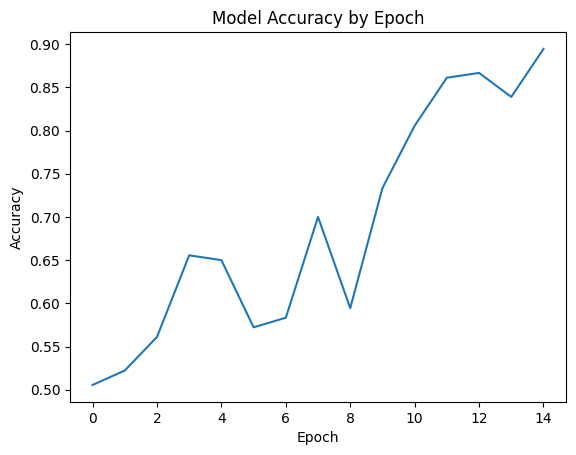

In [10]:
#Plotting Accuracies
plt.plot(list_of_accuracy_values)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Model Accuracy by Epoch")

In [11]:
#Find accuracy of model run on validation set
acc = model.evaluate(model, val_loader, classes, device)
print(f"Accuracy on the validation data: {acc * 100:.2f}%")

Accuracy on the validation data: 60.00%


In [12]:
#Find accuracy of model run on test set
acc = model.evaluate(model, test_loader, classes, device)
print(f"Accuracy on the test data: {acc * 100:.2f}%")

Accuracy on the test data: 46.67%
